The execution of entire notebook takes 2 minutes on my machine and may vary from machine to machine. (Majority of time is taken by monte carlo prediction) Instructions to access details about time taken by each of the algorithm are in the last couple of cells.*

# Question 1

### Value Iteration Setup

In [1]:
# importing dependencies

import gym
import numpy as np
import time
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)

In [2]:
# function for value iteration

def value_iteration(env, gamma, eps = 1e-12):
    elapsed = time.time()
    num_states = env.nS
    transition = env.env.P
    value_function = np.zeros(num_states)
    num_iterations = 0
    
    delta = float('inf')
    while (delta >= eps):
        num_iterations += 1
        delta = 0
        for state in range(num_states):
            prev_value = value_function[state]
            for action in transition[state]:
                updated_value = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    updated_value += prob * (reward + gamma * value_function[next_state])
                value_function[state] = max(value_function[state], updated_value)
            delta = max(delta, abs(value_function[state] - prev_value))
    
    policy = np.zeros(num_states)
    for state in range(num_states):
        val = float('-inf')
        for action in transition[state]:
            return_val = 0
            for prob, next_state, reward, is_terminal in transition[state][action]:
                    return_val += prob * (reward + gamma * value_function[next_state])
            if (return_val > val):
                val = return_val
                policy[state] = action
    elapsed = time.time() - elapsed
    return value_function, policy, num_iterations, elapsed

### Value Iteration on Frozen Lake environment and storing results

In [3]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('FrozenLake8x8-v0')
results_fl_vi = {}
start_fl_vi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = value_iteration(env, gamma)
    results_fl_vi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Value Iteration on Taxi environment and storing results

In [4]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('Taxi-v3')
results_taxi_vi = {}
start_taxi_vi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = value_iteration(env, gamma)
    results_taxi_vi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}



### Functions to display results

In [5]:
def print_result_FrozenLake(results, gamma):
    
    print(f'\ngamma: {gamma}\n')
    
    value_function = results[gamma]['value_function']
    policy = results[gamma]['policy']
    num_iterations = results[gamma]['num_iterations']
    
    
    print("Value Function:")
    for i in range(8):
        for j in range(8):
            print(format(value_function[8*i+j], '.2f'), end = ' ')
        print()
    print()
    
    print("Policy:")
    mapping = {0: 'L', 1: 'U', 2: 'R', 3: 'D'}
    for i in range(8):
        for j in range(8):
            print(f' {mapping[policy[8*i+j]]}  ', end = ' ')
        print()
    print()
    
    print(f'Number of Iterations: {num_iterations}')
    print('-------------------------------------------------------------')

In [6]:
def plot_gamma_iterations(**kwargs):
    
    num_plots = len(kwargs)
    fig, axs = plt.subplots(1, num_plots+1)
    plot_cnt = 0
    
    for label in kwargs:
        results = kwargs[label]
        x, y = [], []
        for gamma in results:
            x.append(gamma)
            y.append(results[gamma]['num_iterations'])
        axs[plot_cnt].plot(x, y, label = label)
        axs[plot_cnt].set_title(label)
        axs[plot_cnt].legend()
        plot_cnt += 1
        if (num_plots > 1):
            axs[num_plots].plot(x, y, label = label)
    if (num_plots > 1):
        axs[num_plots].set_title("Combined")
        axs[num_plots].legend()
    fig.tight_layout()

In [7]:
def plot_gamma_value(**kwargs):
    
    num_plots = len(kwargs)
    fig, axs = plt.subplots(1, num_plots+1)
    plot_cnt = 0
    
    for label in kwargs:
        results, start = kwargs[label]
        x, y = [], []
        for gamma in results:
            x.append(gamma)
            #y.append(results[gamma]['value_function'][start])
            y.append(max(results[gamma]['value_function']))
        axs[plot_cnt].plot(x, y, label = label)
        axs[plot_cnt].set_title(label)
        axs[plot_cnt].legend()
        plot_cnt += 1
        if (num_plots > 1):
            axs[num_plots].plot(x, y, label = label)
    if (num_plots > 1):
        axs[num_plots].set_title("Combined")
        axs[num_plots].legend()
    fig.tight_layout()

### Number of Iterations v/s Gamma Plot

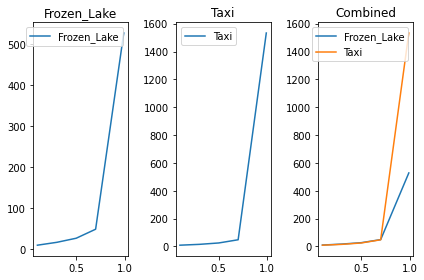

In [8]:
plot_gamma_iterations(Frozen_Lake = results_fl_vi, Taxi = results_taxi_vi)

### State Value of start state v/s Gamma Plot
```
y-axis has:
max norm of value function in case of taxi
value function of start state (0) in case of frozen_lake
```

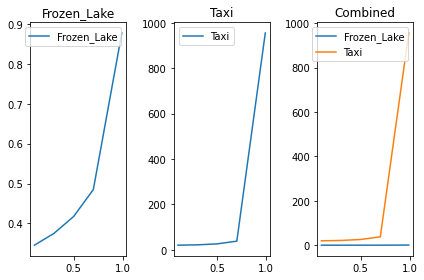

In [9]:
plot_gamma_value(Frozen_Lake = (results_fl_vi, start_fl_vi), Taxi = (results_taxi_vi, start_taxi_vi))

### Observations


Different values of gamma gives different policy using value iteration. The reason to this is that a different gamma corresponds to an entirely different goal. Whereas lower values of gamma tend to have a policy which gives higher rewards in immediate future, the larger gamma values have a policy which gives higher reward sum (discounted) in longer runs.

Thus, lower gamma corresponds to a short sighted agent whereas a higher gamma corresponds to a far sighted agent.

Because of larger state space of taxi environment, it takes more iterations until the value function converges in case of taxi environment than in frozen lake environment.

For higher gamma, the returns are higher which essentially means that a far sighted agent would perform better.

# Question 2

### Policy Iteration Setup

In [10]:
# function for policy iteration

def policy_iteration(env, gamma, eps = 1e-12):
    elapsed = time.time()
    num_states = env.nS
    transition = env.env.P    
    
    policy = [np.random.choice(list(transition[state].keys())) for state in range(num_states)]
    value_function = np.zeros(num_states)#
    
    def policy_evaluation():
        #value_function = np.zeros(num_states)
        num_iterations = 0
        
        while (True):
            num_iterations += 1
            delta = float('-inf')
            #value_function_ = np.zeros(num_states)

            for state in range(num_states):
                prev_value = value_function[state]#
                action = policy[state]
                updated_value = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    updated_value += prob * (reward + gamma * value_function[next_state])
                #value_function_[state] = max(value_function[state], updated_value)
                #delta = max(delta, abs(value_function_[state] - value_function[state]))
                value_function[state] = max(value_function[state], updated_value)#
                delta = max(delta, abs(value_function[state] - prev_value))#
                   
            #value_function = value_function_.copy()
            if (delta < eps):
                break
        return value_function, num_iterations
    
    def policy_improvement(value_function):
        has_converged = True
        for state in range(num_states):
            prev_action = policy[state]
            max_return = float('-inf')
            best_action = -1
            for action in transition[state]:
                returns = 0
                for prob, next_state, reward, is_terminal in transition[state][action]:
                    returns += prob * (reward + gamma * value_function[next_state])
                if (returns > max_return or (returns == max_return and action == prev_action)):
                    max_return, best_action = returns, action
            if (best_action != prev_action):
                has_converged = False
            
            policy[state] = best_action
        return has_converged
    
    num_iterations = 0
    while (True):
        value_function, iterations = policy_evaluation()
        num_iterations += iterations
        has_converged = policy_improvement(value_function)
        if (has_converged):
            break
    
    elapsed = time.time() - elapsed
    return value_function, policy, num_iterations, elapsed
    

### Policy Iteration on Frozen Lake environment and storing results

In [11]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('FrozenLake8x8-v0')
results_fl_pi = {}
start_fl_pi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = policy_iteration(env, gamma)
    results_fl_pi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Policy Iteration on Taxi environment and storing results

In [12]:
# setting up environment
# running value iteration for different values of gamma and storing them in a dictionary

env = gym.make('Taxi-v3')
results_taxi_pi = {}
start_taxi_pi = env.env.s

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, policy, num_iterations, elapsed_time = policy_iteration(env, gamma)
    results_taxi_pi[gamma] = {'value_function': value_function, 'policy': policy, 'num_iterations': num_iterations, 'time': elapsed_time}

### Number of Iterations v/s Gamma Plot

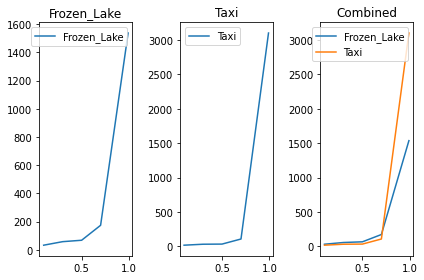

In [13]:
plot_gamma_iterations(Frozen_Lake = results_fl_pi, Taxi = results_taxi_pi)

### Value of start state v/s Gamma Plot
```
y-axis has:
max norm of value function in case of taxi
value function of start state (0) in case of frozen_lake
```

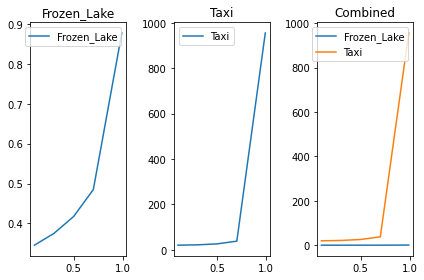

In [14]:
plot_gamma_value(Frozen_Lake = (results_fl_pi, start_fl_pi), Taxi = (results_taxi_pi, start_taxi_pi))

### Observations

Policy converges earlier than the value function. In fact, the last iteration is an extra iteration to confirm that there is no change in policy and hence the policy has converged. However, the value function still gets updated.

Also, in implementation I don't wait for the value function to converge till the difference becomes 0. I take a small constant *eps* which is the limit of convergence of the value function.

# Question 3

*Value Iteration* uses **less number of iterations** than *Policy Iteration* but is overall **slower (takes more time)** as it involves argmax over all possible actions in each state which makes every iteration of *Value Iteration* more expensive as compared to that of *policy iteration*.

Following are the statistics for the number of iterations taken:
*(for epsilon = 1e-12)*

| | Number of Iterations | |
| :-: | :-: | :-: |
| Environment | Value Iteration | Policy Iteration |
| Frozen_Lake | 500 | 1600 |
| Taxi | 1600 | 3000 |


| | Time taken | |
| :-: | :-: | :-: |
| Environment | Value Iteration | Policy Iteration |
| Frozen_Lake | 0.49 | 0.45 |
| Taxi | 10 | 5 |

The reason as to why value iteration takes less number of iterations is:
It combines the policy evaluation and policy improvement step by making updates to the value function directly, hence the faster convergence.

The reason as to why value iteration still takes more time is:
It involves argmax over all possible actions in each state which makes every iteration of *Value Iteration* more expensive as compared to that of *Policy Iteration* and hence greater execution time.


# Question 4

### Monte Carlo Prediction

In [15]:
def monte_carlo(env, gamma, policy, eps = 1e-12):
    elapsed = time.time()
    num_iterations = 0
    actions = list(range(env.env.action_space.n))
    num_states = env.env.observation_space.n
    value_function = [[0, 0] for i in range(num_states)]
    
    for _ in range(int(1e5)):
        num_iterations += 1
        state = env.reset()
        episode = []
        done = False
        maxDiff = [0 for i in range(num_states)]
        
        times_visited = [0 for i in range(num_states)]
        
        while (done == False):
            times_visited[state] += 1
            action = policy[state]
            next_state, reward, done, info = env.step(action)
            episode.append([state, action, reward, next_state])
            state = next_state

        g = 0
        for state, action, reward, next_state in episode[::-1]:
            prev = value_function[state][0]
            g = gamma*g + reward
            
            if (times_visited[state] != 1):
                times_visited[state] -= 1
                continue
            
            value_function[state][1] += 1
            value_function[state][0] = value_function[state][0] + (g - value_function[state][0]) / value_function[state][1]
            
            maxDiff[state] = abs(value_function[state][0] - prev)

    value_function = [i[0] for i in value_function]
    elapsed = time.time() - elapsed
    return value_function, num_iterations, elapsed

In [16]:
# setting up environment
# running monte carlo for different values of gamma and storing them in a dictionary

env = gym.make('FrozenLake8x8-v0')
results_fl_mc = {}

for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    value_function, num_iterations, elapsed_time = monte_carlo(env, gamma, results_fl_vi[gamma]['policy'])
    results_fl_mc[gamma] = {'value_function': value_function, 'num_iterations': num_iterations, 'time': elapsed_time}

### Value function vs State plot

0.1


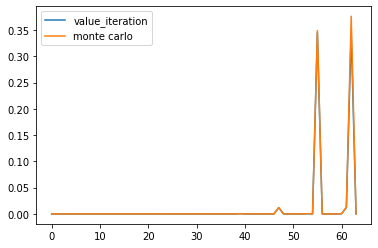

0.3


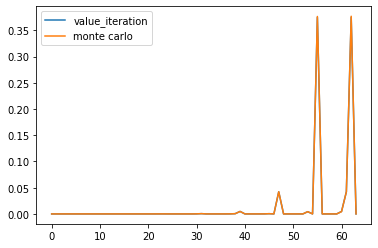

0.5


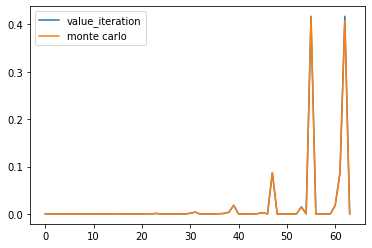

0.7


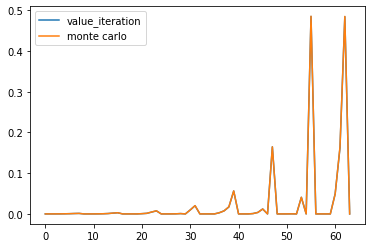

0.99


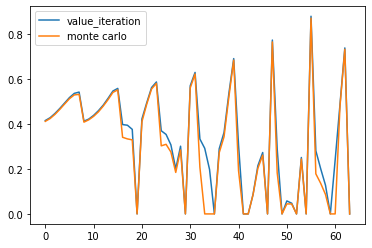

In [17]:
for gamma in [0.1, 0.3, 0.5, 0.7, 0.99]:
    print(gamma)
    plt.plot(list(range(env.env.observation_space.n)), list(results_fl_vi[gamma]['value_function']), label='value_iteration')
    plt.plot(list(range(env.env.observation_space.n)), list(results_fl_mc[gamma]['value_function']), label='monte carlo')
    plt.legend()
    plt.show()

### Observations

The monte carlo converges very slowly for larger values of gamma because larger gamma would mean that the errors in further states causes considerable errors in the state for which value function is being computed. This can also be observed in above plots. Even after 1 million iterations, value functions in case of monte carlo and value iteration differ a bit.

This clearly signifies how much experience is required for value function estimation if the model of environment is not present.

The plots clearly depict that value functions using both the algorithms are nearly equal, thus showing convergence in monte carlo.

### See results
Results of policy iteration, value iteration on each of the taxi and frozen lake environment, and  monte carlo prediction on frozen lake in dictionaries. The keys of these dictionaries are gamma values and the corresponding values are dictionaries having details like the value function, number of iterations, time taken etc.
Following are the details for the same:

| | Dictionaries to access results | |
| :-: | :-: | :-: |
| **Environment** | **Algorithm** | **Dictionary** |
| Frozen_Lake | Value Iteration | results_fl_vi |
| Frozen_Lake | Policy Iteration | results_fl_pi |
| Frozen_Lake | Monte Carlo | results_fl_mc |
| Taxi | Value Iteration | results_taxi_vi |
| Taxi | Policy Iteration | results_taxi_pi |

Examples to access these results are given in next few cells.

In [18]:
results_fl_vi[0.99].keys()

dict_keys(['value_function', 'policy', 'num_iterations', 'time'])

In [19]:
results_fl_mc[0.7].keys()

dict_keys(['value_function', 'num_iterations', 'time'])

In [20]:
results_fl_vi[0.99]['time']

0.47725605964660645

In [21]:
results_fl_mc[0.99]['time']

72.27220511436462

In [22]:
results_taxi_pi[0.99]['num_iterations']

3100